In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

In [ ]:
df_train = pd.read_csv('DailyDelhiClimateTrain.csv', parse_dates=True)
df_test = pd.read_csv('DailyDelhiClimateTest.csv', parse_dates=True)

In [ ]:
df_train.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [ ]:
df_test.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2017-01-01,15.913043,85.869565,2.743478,59.000000
1,2017-01-02,18.500000,77.222222,2.894444,1018.277778
2,2017-01-03,17.111111,81.888889,4.016667,1018.333333
3,2017-01-04,18.700000,70.050000,4.545000,1015.700000
4,2017-01-05,18.388889,74.944444,3.300000,1014.333333


In [ ]:
df_train.shape, df_test.shape

((1462, 5), (114, 5))

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          1462 non-null   object 
 1   meantemp      1462 non-null   float64
 2   humidity      1462 non-null   float64
 3   wind_speed    1462 non-null   float64
 4   meanpressure  1462 non-null   float64
dtypes: float64(4), object(1)
memory usage: 57.2+ KB


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          114 non-null    object 
 1   meantemp      114 non-null    float64
 2   humidity      114 non-null    float64
 3   wind_speed    114 non-null    float64
 4   meanpressure  114 non-null    float64
dtypes: float64(4), object(1)
memory usage: 4.6+ KB


In [ ]:
df_train.isnull().sum()

,0
date,0
meantemp,0
humidity,0
wind_speed,0
meanpressure,0


In [ ]:
df_test.isnull().sum()

,0
date,0
meantemp,0
humidity,0
wind_speed,0
meanpressure,0


In [ ]:
df_train['date'] = pd.to_datetime(df_train['date'])
df_train = df_train.sort_values(by='date')

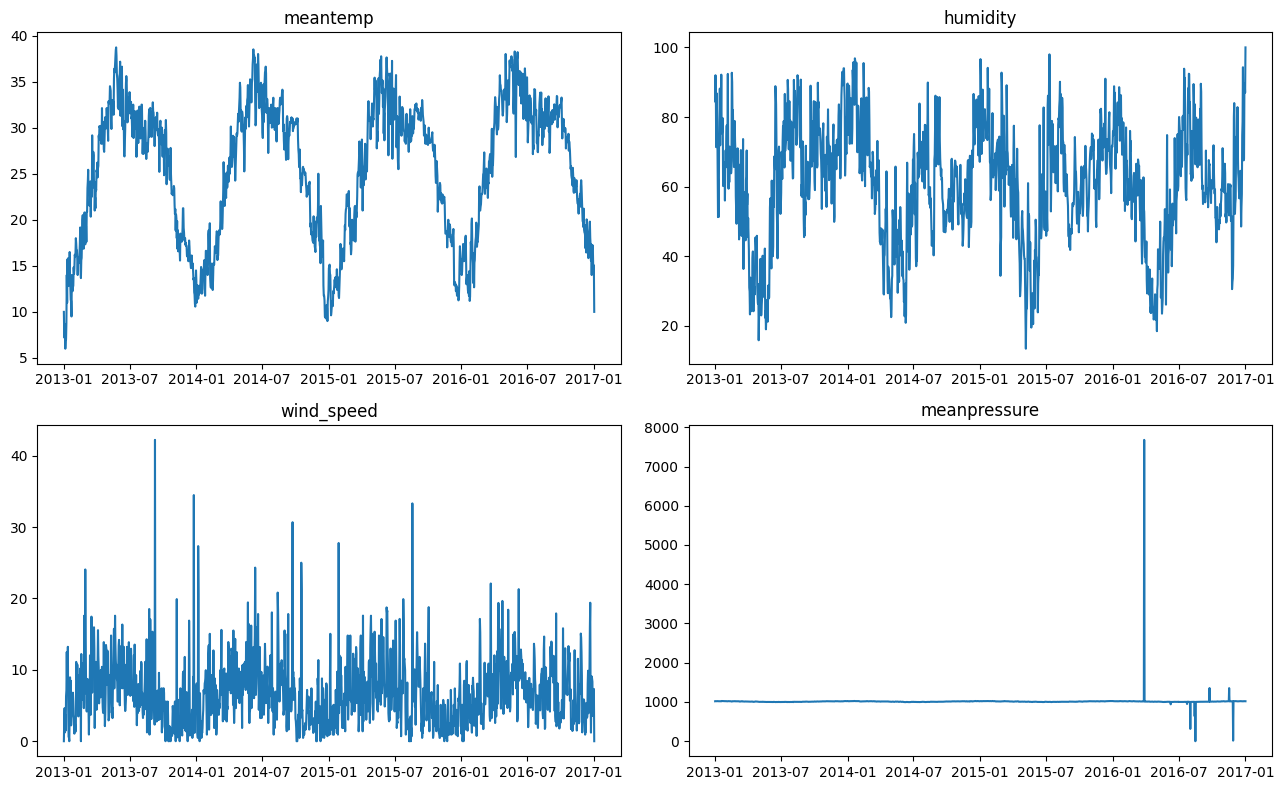

In [ ]:
plt.figure(figsize=(13,8))
plt.subplot(2,2,1)
plt.plot(df_train['date'], df_train['meantemp'])
plt.title('meantemp')

plt.subplot(2,2,2)
plt.plot(df_train['date'], df_train['humidity'])
plt.title('humidity')

plt.subplot(2,2,3)
plt.plot(df_train['date'], df_train['wind_speed'])
plt.title('wind_speed')

plt.subplot(2,2,4)
plt.plot(df_train['date'], df_train['meanpressure'])
plt.title('meanpressure')
plt.tight_layout()
plt.show()

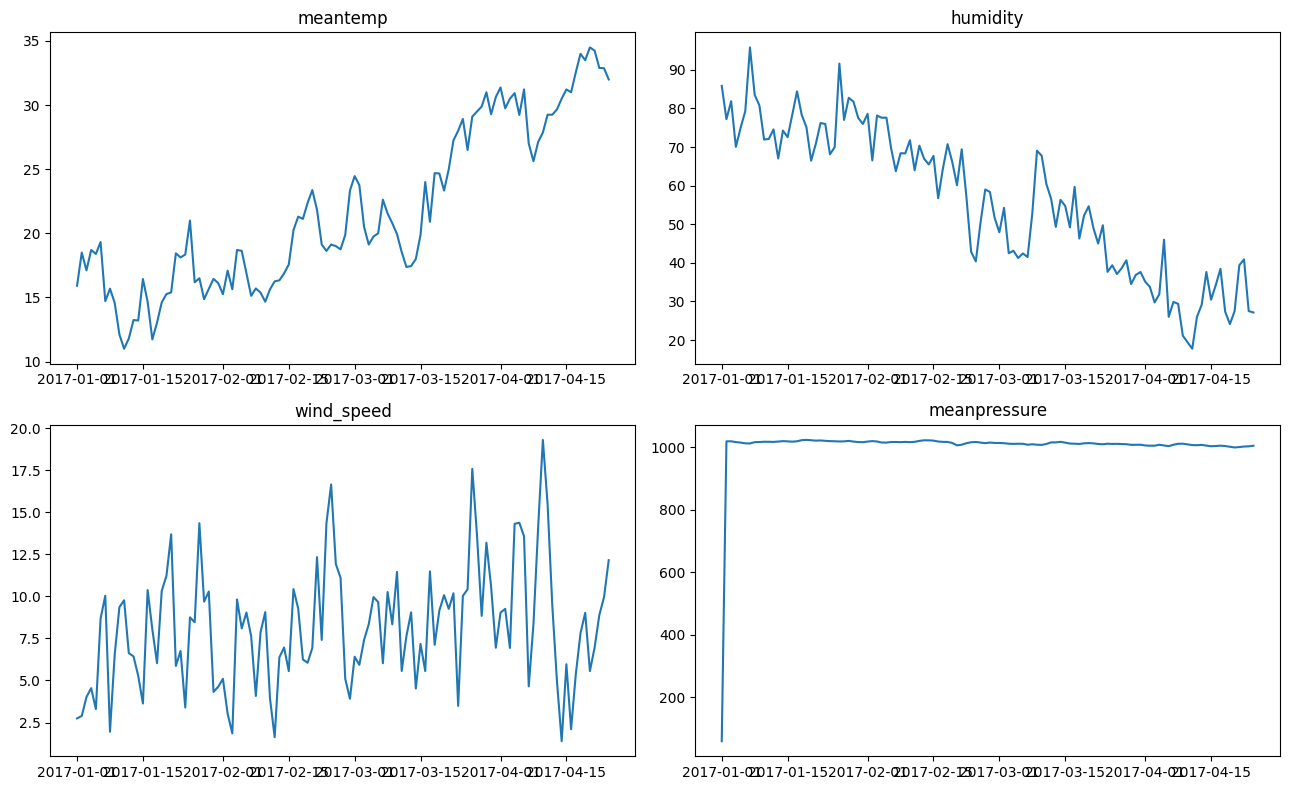

In [ ]:
df_test['date'] = pd.to_datetime(df_test['date'])
df_test = df_test.sort_values(by='date')


plt.figure(figsize=(13,8))
plt.subplot(2,2,1)
plt.plot(df_test['date'], df_test['meantemp'])
plt.title('meantemp')

plt.subplot(2,2,2)
plt.plot(df_test['date'], df_test['humidity'])
plt.title('humidity')

plt.subplot(2,2,3)
plt.plot(df_test['date'], df_test['wind_speed'])
plt.title('wind_speed')

plt.subplot(2,2,4)
plt.plot(df_test['date'], df_test['meanpressure'])
plt.title('meanpressure')
plt.tight_layout()
plt.show()

In [ ]:
def custom_df(df: pd.DataFrame, target_column: str, feature_columns: list, look_back=1) -> np.array:
    df_temp = df.copy()

    scaler_features = MinMaxScaler(feature_range=(0, 1))
    scaler_target = MinMaxScaler(feature_range=(0, 1))

    scaled_features = scaler_features.fit_transform(df_temp[feature_columns])
    scaled_target = scaler_target.fit_transform(df_temp[[target_column]])
    scaled_data = np.concatenate((scaled_features, scaled_target), axis=1)

    X_temp, y_temp = [], []
    for i in range(len(scaled_data) - look_back):
        X_temp.append(scaled_data[i:(i + look_back), :-1])
        y_temp.append(scaled_data[i + look_back, -1])

    X_temp = np.array(X_temp)
    y_temp = np.array(y_temp)

    X_dif = X_temp[:-1] - X_temp[1:]
    X_temp = np.hstack([X_temp[:-1], X_dif])
    y_temp = y_temp[:-1]

    y_dif = y_temp[:-1] - y_temp[1:]
    y_temp = y_temp[:-1]
    X_temp = X_temp[:-1]

    y_dif = y_dif.reshape(-1, 1, 1)
    y_dif = np.repeat(y_dif, X_temp.shape[1], axis=1)
    X_temp = np.concatenate([X_temp, y_dif], axis=2)

    y_temp = y_temp[1:]
    X_temp = X_temp[:-1]

    return X_temp, y_temp, scaler_target

In [ ]:
df_test.loc[0, 'meanpressure'] = df_test['meanpressure'].mean()

In [ ]:
# Убираем выбросы
df_train = df_train[(df_train['meanpressure']>=950) & (df_train['meanpressure']<=1050)]
df_test = df_test[(df_test['meanpressure']>=950) & (df_test['meanpressure']<=1050)]

# RNN - Recurrent Neural Network

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from keras.callbacks import EarlyStopping

meantemp

In [ ]:
X_train_meantemp, y_train_meantemp, scaler_target_train_meantemp  = custom_df(df=df_train,
                                                                              target_column='meantemp',
                                                                              feature_columns=['meantemp','humidity', 'wind_speed', 'meanpressure'],
                                                                              look_back=5)

X_test_meantemp, y_test_meantemp, scaler_target_test_meantemp  = custom_df(df=df_test,
                                                                           target_column='meantemp',
                                                                           feature_columns=['meantemp','humidity', 'wind_speed', 'meanpressure'],
                                                                           look_back=5)

In [ ]:
model = Sequential()
# Входной слой
model.add(SimpleRNN(50, activation='relu', input_shape=(X_train_meantemp.shape[1], X_train_meantemp.shape[2]), return_sequences=True))
# Дополнительные слои
model.add(SimpleRNN(50, activation='relu', return_sequences=True))
model.add(SimpleRNN(50, activation='relu'))
# Выходной слой
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1, restore_best_weights=True)
model.fit(X_train_meantemp, y_train_meantemp, epochs=300, batch_size=64, validation_data=(X_test_meantemp, y_test_meantemp), callbacks=early_stopping)

In [ ]:
pred = model.predict(X_test_meantemp)
pred_inv_meantemp = scaler_target_test_meantemp.inverse_transform(pred)  # Обратное преобразование, тк ранее делали нормализацию
y_test_inv_meantemp = scaler_target_test_meantemp.inverse_transform(y_test_meantemp.reshape(-1, 1))

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


humidity

In [ ]:
X_train_humidity, y_train_humidity, scaler_target_train_humidity  = custom_df(df=df_train,
                                                                              target_column='humidity',
                                                                              feature_columns=['meantemp','humidity', 'wind_speed', 'meanpressure'],
                                                                              look_back=5)

X_test_humidity, y_test_humidity, scaler_target_test_humidity  = custom_df(df=df_test,
                                                                           target_column='humidity',
                                                                           feature_columns=['meantemp','humidity', 'wind_speed', 'meanpressure'],
                                                                           look_back=5)

In [ ]:
model = Sequential()
# Входной слой
model.add(SimpleRNN(50, activation='relu', input_shape=(X_train_humidity.shape[1], X_train_humidity.shape[2]), return_sequences=True))
# Дополнительные слои
model.add(SimpleRNN(50, activation='relu', return_sequences=True))
model.add(SimpleRNN(50, activation='relu'))
# Выходной слой
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1, restore_best_weights=True)
model.fit(X_train_humidity, y_train_humidity, epochs=300, batch_size=64, validation_data=(X_test_humidity, y_test_humidity), callbacks=early_stopping)

In [ ]:
pred = model.predict(X_test_humidity)
pred_inv_humidity = scaler_target_test_humidity.inverse_transform(pred)
y_test_inv_humidity = scaler_target_test_humidity.inverse_transform(y_test_humidity.reshape(-1, 1))

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step


wind_speed

In [ ]:
X_train_wind_speed, y_train_wind_speed, scaler_target_train_wind_speed  = custom_df(df=df_train,
                                                                                    target_column='wind_speed',
                                                                                    feature_columns=['meantemp','humidity', 'wind_speed', 'meanpressure'],
                                                                                    look_back=5)

X_test_wind_speed, y_test_wind_speed, scaler_target_test_wind_speed  = custom_df(df=df_test,
                                                                                 target_column='wind_speed',
                                                                                 feature_columns=['meantemp','humidity', 'wind_speed', 'meanpressure'],
                                                                                 look_back=5)

In [ ]:
model = Sequential()
# Входной слой
model.add(SimpleRNN(50, activation='relu', input_shape=(X_train_wind_speed.shape[1], X_train_wind_speed.shape[2]), return_sequences=True))
# Дополнительные слои
model.add(SimpleRNN(50, activation='relu', return_sequences=True))
model.add(SimpleRNN(50, activation='relu'))
# Выходной слой
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1, restore_best_weights=True)
model.fit(X_train_wind_speed, y_train_wind_speed, epochs=300, batch_size=64, validation_data=(X_test_wind_speed, y_test_wind_speed), callbacks=early_stopping)

In [ ]:
pred = model.predict(X_test_wind_speed)
pred_inv_wind_speed = scaler_target_test_wind_speed.inverse_transform(pred)
y_test_inv_wind_speed = scaler_target_test_wind_speed.inverse_transform(y_test_wind_speed.reshape(-1, 1))

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


meanpressure

In [ ]:
X_train_meanpressure, y_train_meanpressure, scaler_target_train_meanpressure  = custom_df(df=df_train,
                                                                                          target_column='meanpressure',
                                                                                          feature_columns=['meantemp','humidity', 'wind_speed', 'meanpressure'],
                                                                                          look_back=5)

X_test_meanpressure, y_test_meanpressure, scaler_target_test_meanpressure  = custom_df(df=df_test,
                                                                                       target_column='meanpressure',
                                                                                       feature_columns=['meantemp','humidity', 'wind_speed', 'meanpressure'],
                                                                                       look_back=5)

In [ ]:
model = Sequential()
# Входной слой
model.add(SimpleRNN(50, activation='relu', input_shape=(X_train_meanpressure.shape[1], X_train_meanpressure.shape[2]), return_sequences=True))
# Дополнительные слои
model.add(SimpleRNN(50, activation='relu', return_sequences=True))
model.add(SimpleRNN(50, activation='relu'))
# Выходной слой
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1, restore_best_weights=True)
model.fit(X_train_meanpressure, y_train_meanpressure, epochs=300, batch_size=64, validation_data=(X_test_meanpressure, y_test_meanpressure), callbacks=early_stopping)

In [ ]:
pred = model.predict(X_test_meanpressure)
pred_inv_meanpressure = scaler_target_test_meanpressure.inverse_transform(pred)
y_test_inv_meanpressure = scaler_target_test_meanpressure.inverse_transform(y_test_meanpressure.reshape(-1, 1))

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


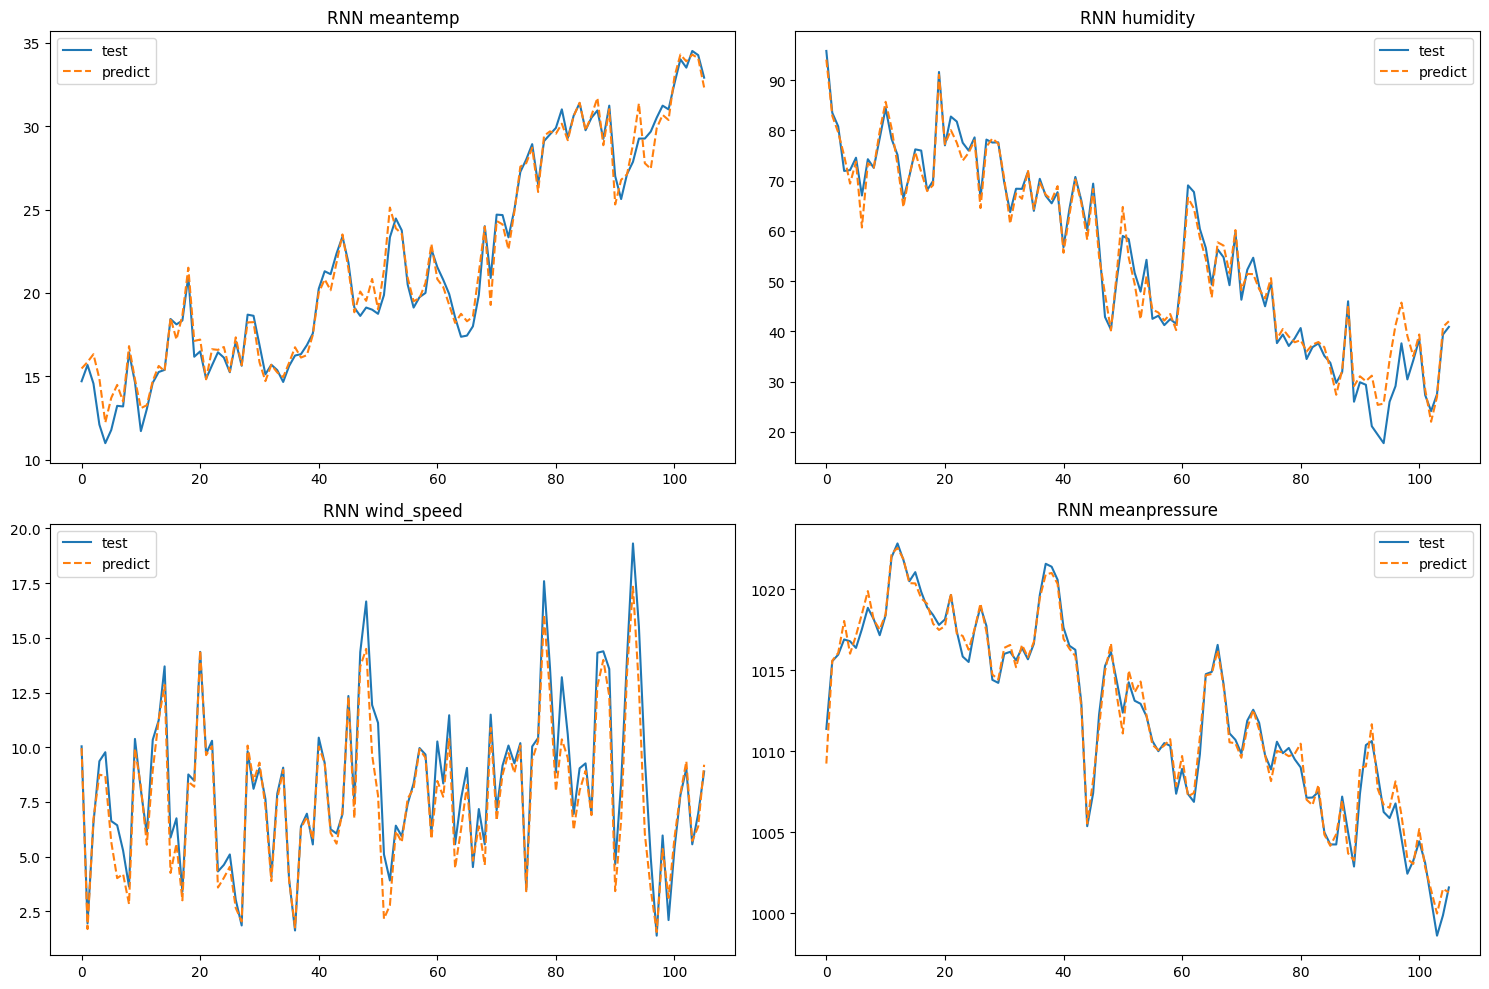

In [ ]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.plot(y_test_inv_meantemp, label='test')
plt.plot(pred_inv_meantemp, label='predict', linestyle='--')
plt.title('RNN meantemp')
plt.legend()

plt.subplot(2,2,2)
plt.plot(y_test_inv_humidity, label='test')
plt.plot(pred_inv_humidity, label='predict', linestyle='--')
plt.title('RNN humidity')
plt.legend()

plt.subplot(2,2,3)
plt.plot(y_test_inv_wind_speed, label='test')
plt.plot(pred_inv_wind_speed, label='predict', linestyle='--')
plt.title('RNN wind_speed')
plt.legend()

plt.subplot(2,2,4)
plt.plot(y_test_inv_meanpressure, label='test')
plt.plot(pred_inv_meanpressure, label='predict', linestyle='--')
plt.title('RNN meanpressure')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): # средняя абсолютная ошибка в процентах
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_rnn_meantemp = mean_absolute_percentage_error(y_test_inv_meantemp, pred_inv_meantemp)
mae_rnn_meantemp = mean_absolute_error(y_test_inv_meantemp, pred_inv_meantemp)
print(f"MAPE meantemp: {mape_rnn_meantemp}%")
print(f"MAE meantemp: {mae_rnn_meantemp}\n")


mape_rnn_humidity = mean_absolute_percentage_error(y_test_inv_humidity, pred_inv_humidity)
mae_rnn_humidity = mean_absolute_error(y_test_inv_humidity, pred_inv_humidity)
print(f"MAPE humidity: {mape_rnn_humidity}%")
print(f"MAE humidity: {mae_rnn_humidity}\n")


mape_rnn_wind_speed = mean_absolute_percentage_error(y_test_inv_wind_speed, pred_inv_wind_speed)
mae_rnn_wind_speed = mean_absolute_error(y_test_inv_wind_speed, pred_inv_wind_speed)
print(f"MAPE wind_speed: {mape_rnn_wind_speed}%")
print(f"MAE wind_speed: {mae_rnn_wind_speed}\n")


mape_rnn_meanpressure = mean_absolute_percentage_error(y_test_inv_meanpressure, pred_inv_meanpressure)
mae_rnn_meanpressure = mean_absolute_error(y_test_inv_meanpressure, pred_inv_meanpressure)
print(f"MAPE meanpressure: {mape_rnn_meanpressure}%")
print(f"MAE meanpressure: {mae_rnn_meanpressure}")

MAPE meantemp: 3.1366862804357574%
MAE meantemp: 0.5985406938007566

MAPE humidity: 5.144072165065041%
MAE humidity: 2.055429284593567

MAPE wind_speed: 9.750720963371807%
MAE wind_speed: 0.7292216714236437

MAPE meanpressure: 0.05106722630201851%
MAE meanpressure: 0.5162887739166014


# RNN with AttentionMechanism

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Dropout

class AttentionMechanism(Layer):
    def __init__(self, return_sequences=True):
        super(AttentionMechanism, self).__init__()
        self.return_sequences = return_sequences

    def build(self, input_shape):
        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1),
                               initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1),
                               initializer="zeros")

    def call(self, x):
        e = tf.nn.tanh(tf.matmul(x,self.W)+self.b)
        a = tf.nn.softmax(e, axis=1)
        output = x*a

        if self.return_sequences:
            return output

        return tf.reduce_sum(output, axis=1)

meantemp

In [ ]:
model = Sequential()

model.add(SimpleRNN(50, activation='relu', input_shape=(X_train_meantemp.shape[1], X_train_meantemp.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(AttentionMechanism(return_sequences=True))  # Внимание
model.add(SimpleRNN(50, return_sequences=False))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1, restore_best_weights=True)
model.fit(X_train_meantemp, y_train_meantemp, epochs=300, batch_size=32, validation_data=(X_test_meantemp, y_test_meantemp), callbacks=early_stopping)

In [ ]:
pred = model.predict(X_test_meantemp)
pred_inv_meantemp = scaler_target_test_meantemp.inverse_transform(pred)  # Обратное преобразование, тк ранее делали нормализацию
y_test_inv_meantemp = scaler_target_test_meantemp.inverse_transform(y_test_meantemp.reshape(-1, 1))

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step


humidity

In [ ]:
model = Sequential()

model.add(SimpleRNN(50, activation='relu', input_shape=(X_train_humidity.shape[1], X_train_humidity.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(AttentionMechanism(return_sequences=True))  # Внимание
model.add(SimpleRNN(50, return_sequences=False))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1, restore_best_weights=True)
model.fit(X_train_humidity, y_train_humidity, epochs=300, batch_size=32, validation_data=(X_test_humidity, y_test_humidity), callbacks=early_stopping)

In [ ]:
pred = model.predict(X_test_humidity)
pred_inv_humidity = scaler_target_test_humidity.inverse_transform(pred)
y_test_inv_humidity = scaler_target_test_humidity.inverse_transform(y_test_humidity.reshape(-1, 1))

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step


wind_speed

In [ ]:
model = Sequential()

model.add(SimpleRNN(50, activation='relu', input_shape=(X_train_wind_speed.shape[1], X_train_wind_speed.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(AttentionMechanism(return_sequences=True))  # Внимание
model.add(SimpleRNN(50, return_sequences=False))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1, restore_best_weights=True)
model.fit(X_train_wind_speed, y_train_wind_speed, epochs=300, batch_size=32, validation_data=(X_test_wind_speed, y_test_wind_speed), callbacks=early_stopping)

In [ ]:
pred = model.predict(X_test_wind_speed)
pred_inv_wind_speed = scaler_target_test_wind_speed.inverse_transform(pred)
y_test_inv_wind_speed = scaler_target_test_wind_speed.inverse_transform(y_test_wind_speed.reshape(-1, 1))

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step


meanpressure

In [ ]:
model = Sequential()

model.add(SimpleRNN(50, activation='relu', input_shape=(X_train_meanpressure.shape[1], X_train_meanpressure.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(AttentionMechanism(return_sequences=True))  # Внимание
model.add(SimpleRNN(50, return_sequences=False))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1, restore_best_weights=True)
model.fit(X_train_meanpressure, y_train_meanpressure, epochs=300, batch_size=32, validation_data=(X_test_meanpressure, y_test_meanpressure), callbacks=early_stopping)

In [ ]:
pred = model.predict(X_test_meanpressure)
pred_inv_meanpressure = scaler_target_test_meanpressure.inverse_transform(pred)
y_test_inv_meanpressure = scaler_target_test_meanpressure.inverse_transform(y_test_meanpressure.reshape(-1, 1))

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step


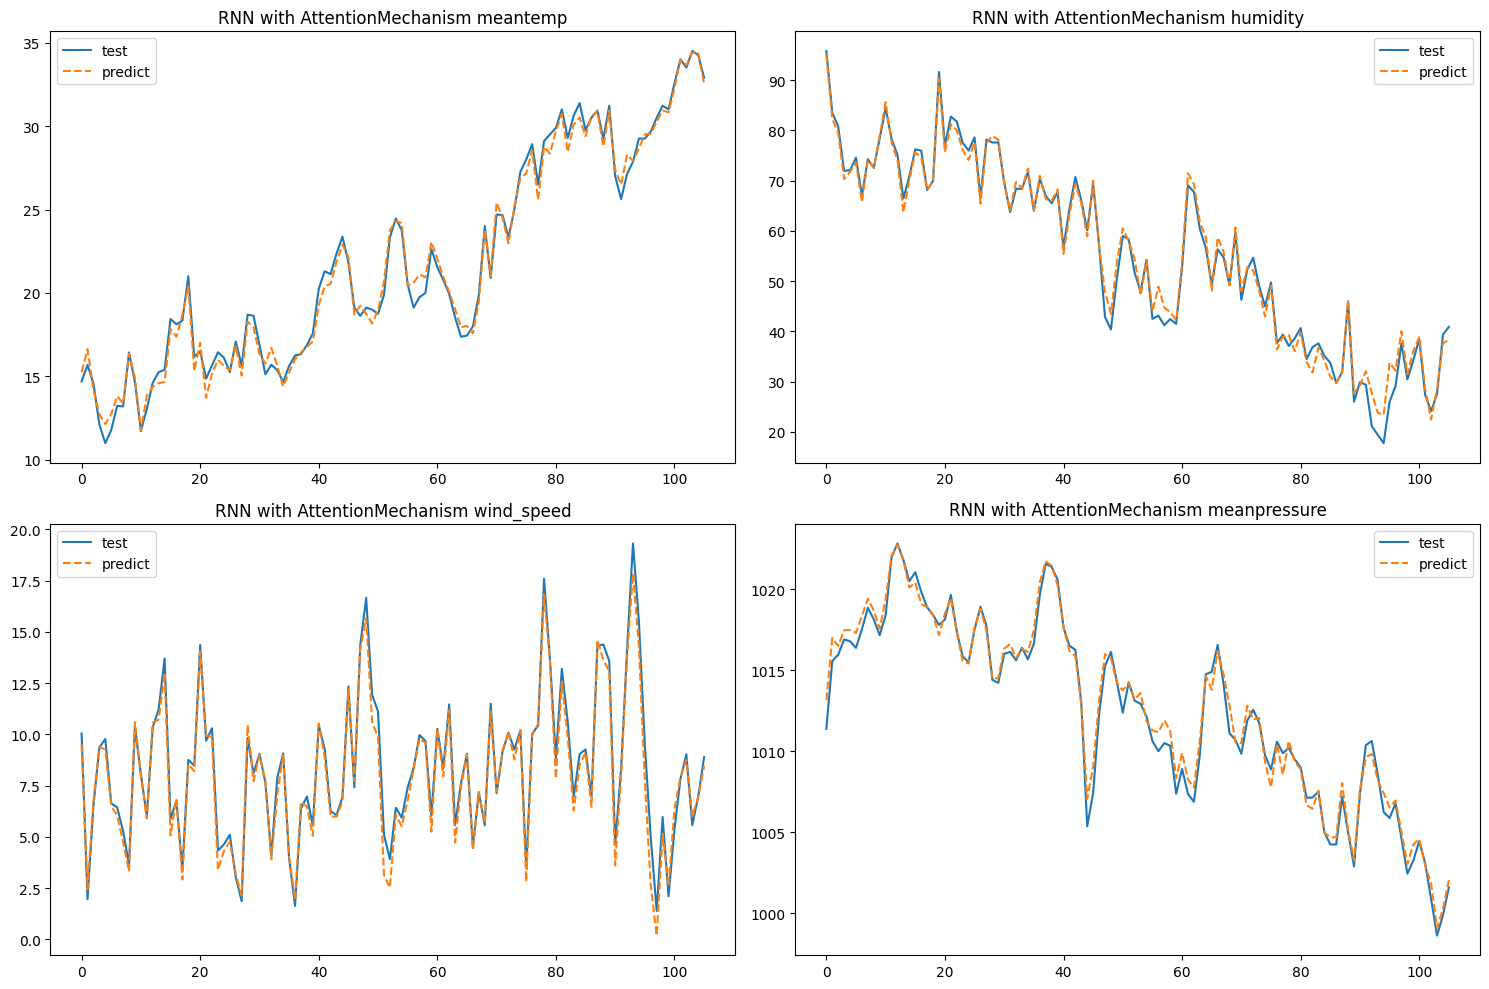

In [ ]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.plot(y_test_inv_meantemp, label='test')
plt.plot(pred_inv_meantemp, label='predict', linestyle='--')
plt.title('RNN with AttentionMechanism meantemp')
plt.legend()

plt.subplot(2,2,2)
plt.plot(y_test_inv_humidity, label='test')
plt.plot(pred_inv_humidity, label='predict', linestyle='--')
plt.title('RNN with AttentionMechanism humidity')
plt.legend()

plt.subplot(2,2,3)
plt.plot(y_test_inv_wind_speed, label='test')
plt.plot(pred_inv_wind_speed, label='predict', linestyle='--')
plt.title('RNN with AttentionMechanism wind_speed')
plt.legend()

plt.subplot(2,2,4)
plt.plot(y_test_inv_meanpressure, label='test')
plt.plot(pred_inv_meanpressure, label='predict', linestyle='--')
plt.title('RNN with AttentionMechanism meanpressure')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
mape_rnn_att_meantemp = mean_absolute_percentage_error(y_test_inv_meantemp, pred_inv_meantemp)
mae_rnn_att_meantemp = mean_absolute_error(y_test_inv_meantemp, pred_inv_meantemp)
print(f"MAPE meantemp: {mape_rnn_att_meantemp}%")
print(f"MAE meantemp: {mae_rnn_att_meantemp}\n")


mape_rnn_att_humidity = mean_absolute_percentage_error(y_test_inv_humidity, pred_inv_humidity)
mae_rnn_att_humidity = mean_absolute_error(y_test_inv_humidity, pred_inv_humidity)
print(f"MAPE humidity: {mape_rnn_att_humidity}%")
print(f"MAE humidity: {mae_rnn_att_humidity}\n")


mape_rnn_att_wind_speed = mean_absolute_percentage_error(y_test_inv_wind_speed, pred_inv_wind_speed)
mae_rnn_att_wind_speed = mean_absolute_error(y_test_inv_wind_speed, pred_inv_wind_speed)
print(f"MAPE wind_speed: {mape_rnn_att_wind_speed}%")
print(f"MAE wind_speed: {mae_rnn_att_wind_speed}\n")


mape_rnn_att_meanpressure = mean_absolute_percentage_error(y_test_inv_meanpressure, pred_inv_meanpressure)
mae_rnn_att_meanpressure = mean_absolute_error(y_test_inv_meanpressure, pred_inv_meanpressure)
print(f"MAPE meanpressure: {mape_rnn_att_meanpressure}%")
print(f"MAE meanpressure: {mae_rnn_att_meanpressure}")

MAPE meantemp: 2.5155187525549687%
MAE meantemp: 0.4817312168471455

MAPE humidity: 3.765002879491909%
MAE humidity: 1.492736974501153

MAPE wind_speed: 7.628059600375045%
MAE wind_speed: 0.45908426454843376

MAPE meanpressure: 0.05337954717132508%
MAE meanpressure: 0.5398516284896273


# LSTM - Long Short-Term Memory

In [ ]:
from tensorflow.keras.layers import LSTM, Dense

meantemp

In [ ]:
model = Sequential()
# Входной слой
model.add(LSTM(50, activation='relu', input_shape=(X_train_meantemp.shape[1], X_train_meantemp.shape[2]), return_sequences=True))
# Дополнительные слои
model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(LSTM(50, activation='relu'))
# Выходной слой
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1, restore_best_weights=True)
model.fit(X_train_meantemp, y_train_meantemp, epochs=300, batch_size=64, validation_data=(X_test_meantemp, y_test_meantemp), callbacks=early_stopping)

In [ ]:
pred = model.predict(X_test_meantemp)
pred_inv_meantemp = scaler_target_test_meantemp.inverse_transform(pred)  # Обратное преобразование, тк ранее делали нормализацию
y_test_inv_meantemp = scaler_target_test_meantemp.inverse_transform(y_test_meantemp.reshape(-1, 1))

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step


humidity

In [ ]:
model = Sequential()
# Входной слой
model.add(LSTM(50, activation='relu', input_shape=(X_train_humidity.shape[1], X_train_humidity.shape[2]), return_sequences=True))
# Дополнительные слои
model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(LSTM(50, activation='relu'))
# Выходной слой
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1, restore_best_weights=True)
model.fit(X_train_humidity, y_train_humidity, epochs=300, batch_size=64, validation_data=(X_test_humidity, y_test_humidity), callbacks=early_stopping)

In [ ]:
pred = model.predict(X_test_humidity)
pred_inv_humidity = scaler_target_test_humidity.inverse_transform(pred)
y_test_inv_humidity = scaler_target_test_humidity.inverse_transform(y_test_humidity.reshape(-1, 1))

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


wind_speed

In [ ]:
model = Sequential()
# Входной слой
model.add(LSTM(50, activation='relu', input_shape=(X_train_wind_speed.shape[1], X_train_wind_speed.shape[2]), return_sequences=True))
# Дополнительные слои
model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(LSTM(50, activation='relu'))
# Выходной слой
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1, restore_best_weights=True)
model.fit(X_train_wind_speed, y_train_wind_speed, epochs=300, batch_size=64, validation_data=(X_test_wind_speed, y_test_wind_speed), callbacks=early_stopping)

In [ ]:
pred = model.predict(X_test_wind_speed)
pred_inv_wind_speed = scaler_target_test_wind_speed.inverse_transform(pred)
y_test_inv_wind_speed = scaler_target_test_wind_speed.inverse_transform(y_test_wind_speed.reshape(-1, 1))

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step


meanpressure

In [ ]:
model = Sequential()
# Входной слой
model.add(LSTM(50, activation='relu', input_shape=(X_train_meanpressure.shape[1], X_train_meanpressure.shape[2]), return_sequences=True))
# Дополнительные слои
model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(LSTM(50, activation='relu'))
# Выходной слой
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1, restore_best_weights=True)
model.fit(X_train_meanpressure, y_train_meanpressure, epochs=300, batch_size=64, validation_data=(X_test_meanpressure, y_test_meanpressure), callbacks=early_stopping)

In [ ]:
pred = model.predict(X_test_meanpressure)
pred_inv_meanpressure = scaler_target_test_meanpressure.inverse_transform(pred)
y_test_inv_meanpressure = scaler_target_test_meanpressure.inverse_transform(y_test_meanpressure.reshape(-1, 1))

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 233ms/step


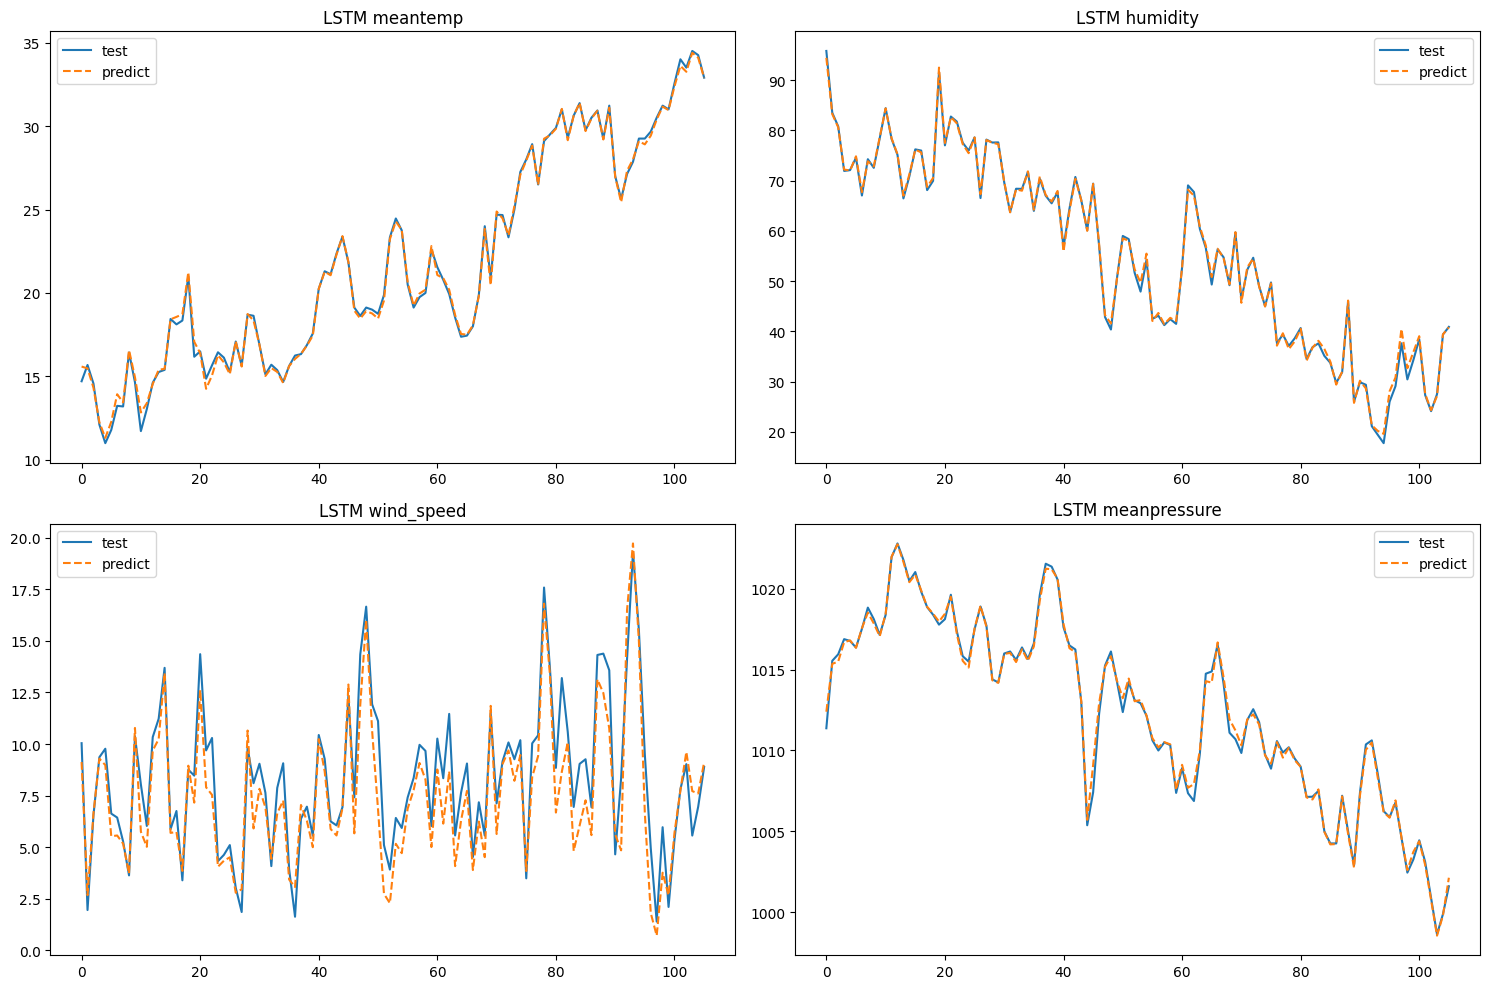

In [ ]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.plot(y_test_inv_meantemp, label='test')
plt.plot(pred_inv_meantemp, label='predict', linestyle='--')
plt.title('LSTM meantemp')
plt.legend()

plt.subplot(2,2,2)
plt.plot(y_test_inv_humidity, label='test')
plt.plot(pred_inv_humidity, label='predict', linestyle='--')
plt.title('LSTM humidity')
plt.legend()

plt.subplot(2,2,3)
plt.plot(y_test_inv_wind_speed, label='test')
plt.plot(pred_inv_wind_speed, label='predict', linestyle='--')
plt.title('LSTM wind_speed')
plt.legend()

plt.subplot(2,2,4)
plt.plot(y_test_inv_meanpressure, label='test')
plt.plot(pred_inv_meanpressure, label='predict', linestyle='--')
plt.title('LSTM meanpressure')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
mape_lstm_meantemp = mean_absolute_percentage_error(y_test_inv_meantemp, pred_inv_meantemp)
mae_lstm_meantemp = mean_absolute_error(y_test_inv_meantemp, pred_inv_meantemp)
print(f"MAPE meantemp: {mape_lstm_meantemp}%")
print(f"MAE meantemp: {mae_lstm_meantemp}\n")


mape_lstm_humidity = mean_absolute_percentage_error(y_test_inv_humidity, pred_inv_humidity)
mae_lstm_humidity = mean_absolute_error(y_test_inv_humidity, pred_inv_humidity)
print(f"MAPE humidity: {mape_lstm_humidity}%")
print(f"MAE humidity: {mae_lstm_humidity}\n")


mape_lstm_wind_speed = mean_absolute_percentage_error(y_test_inv_wind_speed, pred_inv_wind_speed)
mae_lstm_wind_speed = mean_absolute_error(y_test_inv_wind_speed, pred_inv_wind_speed)
print(f"MAPE wind_speed: {mape_lstm_wind_speed}%")
print(f"MAE wind_speed: {mae_lstm_wind_speed}\n")


mape_lstm_meanpressure = mean_absolute_percentage_error(y_test_inv_meanpressure, pred_inv_meanpressure)
mae_lstm_meanpressure = mean_absolute_error(y_test_inv_meanpressure, pred_inv_meanpressure)
print(f"MAPE meanpressure: {mape_lstm_meanpressure}%")
print(f"MAE meanpressure: {mae_lstm_meanpressure}")

MAPE meantemp: 1.0427189893832847%
MAE meantemp: 0.1848936769950756

MAPE humidity: 1.1496634591222057%
MAE humidity: 0.4779926298764388

MAPE wind_speed: 16.22474760690521%
MAE wind_speed: 1.1538915806755792

MAPE meanpressure: 0.020895447933057698%
MAE meanpressure: 0.21138859036776178


# LSTM with AttentionMechanism

meantemp

In [ ]:
model = Sequential()

model.add(LSTM(50, activation='relu', input_shape=(X_train_meantemp.shape[1], X_train_meantemp.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(AttentionMechanism(return_sequences=True))  # Внимание
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1, restore_best_weights=True)
model.fit(X_train_meantemp, y_train_meantemp, epochs=300, batch_size=32, validation_data=(X_test_meantemp, y_test_meantemp), callbacks=early_stopping)

In [ ]:
pred = model.predict(X_test_meantemp)
pred_inv_meantemp = scaler_target_test_meantemp.inverse_transform(pred)  # Обратное преобразование, тк ранее делали нормализацию
y_test_inv_meantemp = scaler_target_test_meantemp.inverse_transform(y_test_meantemp.reshape(-1, 1))

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step


humidity

In [ ]:
model = Sequential()

model.add(LSTM(50, activation='relu', input_shape=(X_train_humidity.shape[1], X_train_humidity.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(AttentionMechanism(return_sequences=True))  # Внимание
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1, restore_best_weights=True)
model.fit(X_train_humidity, y_train_humidity, epochs=300, batch_size=32, validation_data=(X_test_humidity, y_test_humidity), callbacks=early_stopping)

In [ ]:
pred = model.predict(X_test_humidity)
pred_inv_humidity = scaler_target_test_humidity.inverse_transform(pred)
y_test_inv_humidity = scaler_target_test_humidity.inverse_transform(y_test_humidity.reshape(-1, 1))

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step


wind_speed

In [ ]:
model = Sequential()

model.add(LSTM(50, activation='relu', input_shape=(X_train_wind_speed.shape[1], X_train_wind_speed.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(AttentionMechanism(return_sequences=True))  # Внимание
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1, restore_best_weights=True)
model.fit(X_train_wind_speed, y_train_wind_speed, epochs=300, batch_size=32, validation_data=(X_test_wind_speed, y_test_wind_speed), callbacks=early_stopping)

In [ ]:
pred = model.predict(X_test_wind_speed)
pred_inv_wind_speed = scaler_target_test_wind_speed.inverse_transform(pred)
y_test_inv_wind_speed = scaler_target_test_wind_speed.inverse_transform(y_test_wind_speed.reshape(-1, 1))

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step


meanpressure

In [ ]:
model = Sequential()

model.add(LSTM(50, activation='relu', input_shape=(X_train_meanpressure.shape[1], X_train_meanpressure.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(AttentionMechanism(return_sequences=True))  # Внимание
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1, restore_best_weights=True)
model.fit(X_train_meanpressure, y_train_meanpressure, epochs=300, batch_size=32, validation_data=(X_test_meanpressure, y_test_meanpressure), callbacks=early_stopping)

In [ ]:
pred = model.predict(X_test_meanpressure)
pred_inv_meanpressure = scaler_target_test_meanpressure.inverse_transform(pred)
y_test_inv_meanpressure = scaler_target_test_meanpressure.inverse_transform(y_test_meanpressure.reshape(-1, 1))

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step


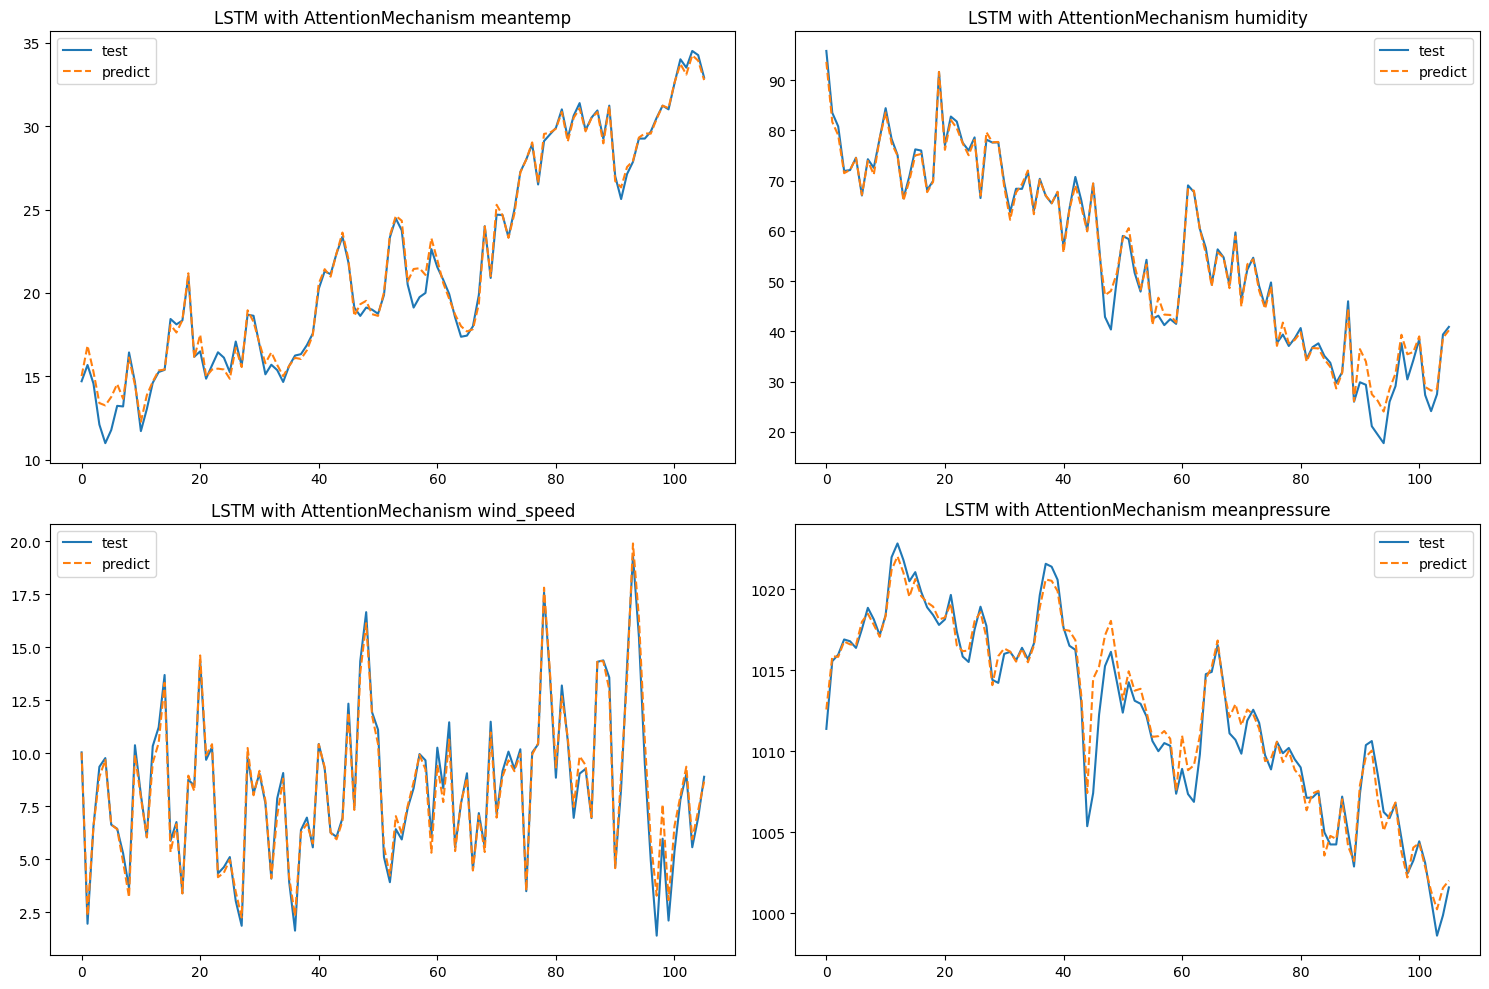

In [ ]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.plot(y_test_inv_meantemp, label='test')
plt.plot(pred_inv_meantemp, label='predict', linestyle='--')
plt.title('LSTM with AttentionMechanism meantemp')
plt.legend()

plt.subplot(2,2,2)
plt.plot(y_test_inv_humidity, label='test')
plt.plot(pred_inv_humidity, label='predict', linestyle='--')
plt.title('LSTM with AttentionMechanism humidity')
plt.legend()

plt.subplot(2,2,3)
plt.plot(y_test_inv_wind_speed, label='test')
plt.plot(pred_inv_wind_speed, label='predict', linestyle='--')
plt.title('LSTM with AttentionMechanism wind_speed')
plt.legend()

plt.subplot(2,2,4)
plt.plot(y_test_inv_meanpressure, label='test')
plt.plot(pred_inv_meanpressure, label='predict', linestyle='--')
plt.title('LSTM with AttentionMechanism meanpressure')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
mape_lstm_att_meantemp = mean_absolute_percentage_error(y_test_inv_meantemp, pred_inv_meantemp)
mae_lstm_att_meantemp = mean_absolute_error(y_test_inv_meantemp, pred_inv_meantemp)
print(f"MAPE meantemp: {mape_lstm_att_meantemp}%")
print(f"MAE meantemp: {mae_lstm_att_meantemp}\n")


mape_lstm_att_humidity = mean_absolute_percentage_error(y_test_inv_humidity, pred_inv_humidity)
mae_lstm_att_humidity = mean_absolute_error(y_test_inv_humidity, pred_inv_humidity)
print(f"MAPE humidity: {mape_lstm_att_humidity}%")
print(f"MAE humidity: {mae_lstm_att_humidity}\n")


mape_lstm_att_wind_speed = mean_absolute_percentage_error(y_test_inv_wind_speed, pred_inv_wind_speed)
mae_lstm_att_wind_speed = mean_absolute_error(y_test_inv_wind_speed, pred_inv_wind_speed)
print(f"MAPE wind_speed: {mape_lstm_att_wind_speed}%")
print(f"MAE wind_speed: {mae_lstm_att_wind_speed}\n")


mape_lstm_att_meanpressure = mean_absolute_percentage_error(y_test_inv_meanpressure, pred_inv_meanpressure)
mae_lstm_att_meanpressure = mean_absolute_error(y_test_inv_meanpressure, pred_inv_meanpressure)
print(f"MAPE meanpressure: {mape_lstm_att_meanpressure}%")
print(f"MAE meanpressure: {mae_lstm_att_meanpressure}")

MAPE meantemp: 2.176065676736837%
MAE meantemp: 0.37275934436624975

MAPE humidity: 3.433251289838932%
MAE humidity: 1.2356993933264597

MAPE wind_speed: 6.522924584600727%
MAE wind_speed: 0.35371844174601114

MAPE meanpressure: 0.07215964623717504%
MAE meanpressure: 0.7296187330141654


# GRU - Gated Recurrent Unit

In [ ]:
from tensorflow.keras.layers import GRU, Dense

meantemp

In [ ]:
model = Sequential()
# Входной слой
model.add(GRU(50, activation='relu', input_shape=(X_train_meantemp.shape[1], X_train_meantemp.shape[2]), return_sequences=True))
# Дополнительные слои
model.add(GRU(50, activation='relu', return_sequences=True))
model.add(GRU(50, activation='relu'))
# Выходной слой
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1, restore_best_weights=True)
model.fit(X_train_meantemp, y_train_meantemp, epochs=300, batch_size=64, validation_data=(X_test_meantemp, y_test_meantemp), callbacks=early_stopping)

In [ ]:
pred = model.predict(X_test_meantemp)
pred_inv_meantemp = scaler_target_test_meantemp.inverse_transform(pred)  # Обратное преобразование, тк ранее делали нормализацию
y_test_inv_meantemp = scaler_target_test_meantemp.inverse_transform(y_test_meantemp.reshape(-1, 1))

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step


humidity

In [ ]:
model = Sequential()
# Входной слой
model.add(GRU(50, activation='relu', input_shape=(X_train_humidity.shape[1], X_train_humidity.shape[2]), return_sequences=True))
# Дополнительные слои
model.add(GRU(50, activation='relu', return_sequences=True))
model.add(GRU(50, activation='relu'))
# Выходной слой
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1, restore_best_weights=True)
model.fit(X_train_humidity, y_train_humidity, epochs=300, batch_size=64, validation_data=(X_test_humidity, y_test_humidity), callbacks=early_stopping)

In [ ]:
pred = model.predict(X_test_humidity)
pred_inv_humidity = scaler_target_test_humidity.inverse_transform(pred)
y_test_inv_humidity = scaler_target_test_humidity.inverse_transform(y_test_humidity.reshape(-1, 1))

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step


wind_speed

In [ ]:
model = Sequential()
# Входной слой
model.add(GRU(50, activation='relu', input_shape=(X_train_wind_speed.shape[1], X_train_wind_speed.shape[2]), return_sequences=True))
# Дополнительные слои
model.add(GRU(50, activation='relu', return_sequences=True))
model.add(GRU(50, activation='relu'))
# Выходной слой
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1, restore_best_weights=True)
model.fit(X_train_wind_speed, y_train_wind_speed, epochs=300, batch_size=64, validation_data=(X_test_wind_speed, y_test_wind_speed), callbacks=early_stopping)

In [ ]:
pred = model.predict(X_test_wind_speed)
pred_inv_wind_speed = scaler_target_test_wind_speed.inverse_transform(pred)
y_test_inv_wind_speed = scaler_target_test_wind_speed.inverse_transform(y_test_wind_speed.reshape(-1, 1))

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step


meanpressure

In [ ]:
model = Sequential()
# Входной слой
model.add(GRU(50, activation='relu', input_shape=(X_train_meanpressure.shape[1], X_train_meanpressure.shape[2]), return_sequences=True))
# Дополнительные слои
model.add(GRU(50, activation='relu', return_sequences=True))
model.add(GRU(50, activation='relu'))
# Выходной слой
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1, restore_best_weights=True)
model.fit(X_train_meanpressure, y_train_meanpressure, epochs=300, batch_size=64, validation_data=(X_test_meanpressure, y_test_meanpressure), callbacks=early_stopping)

In [ ]:
pred = model.predict(X_test_meanpressure)
pred_inv_meanpressure = scaler_target_test_meanpressure.inverse_transform(pred)
y_test_inv_meanpressure = scaler_target_test_meanpressure.inverse_transform(y_test_meanpressure.reshape(-1, 1))

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 275ms/step


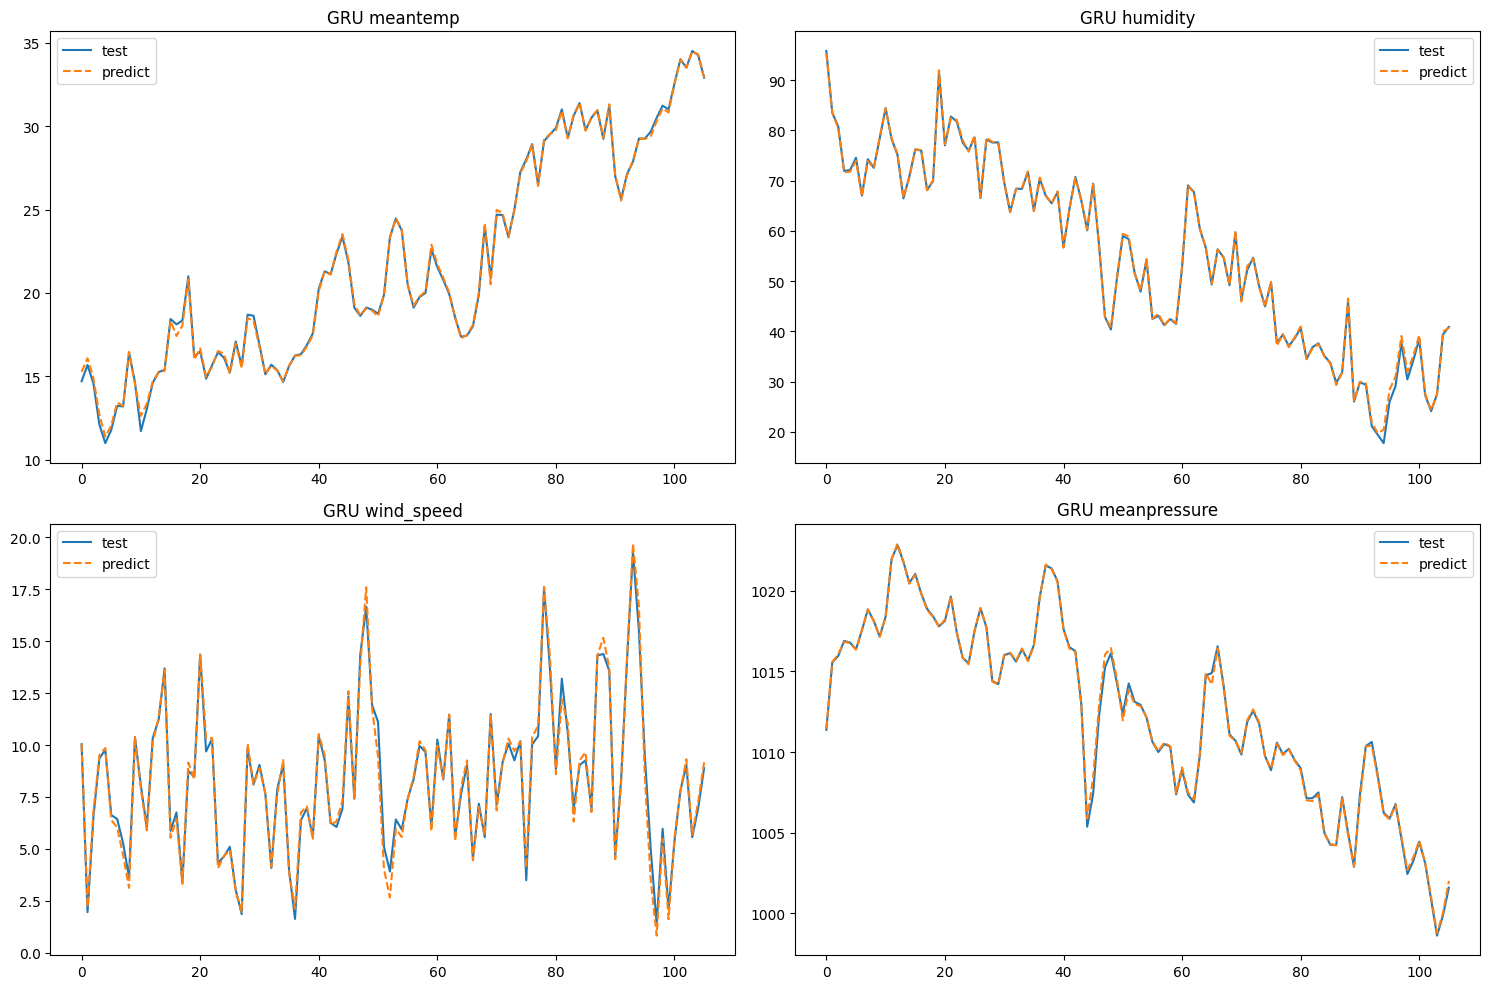

In [ ]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.plot(y_test_inv_meantemp, label='test')
plt.plot(pred_inv_meantemp, label='predict', linestyle='--')
plt.title('GRU meantemp')
plt.legend()

plt.subplot(2,2,2)
plt.plot(y_test_inv_humidity, label='test')
plt.plot(pred_inv_humidity, label='predict', linestyle='--')
plt.title('GRU humidity')
plt.legend()

plt.subplot(2,2,3)
plt.plot(y_test_inv_wind_speed, label='test')
plt.plot(pred_inv_wind_speed, label='predict', linestyle='--')
plt.title('GRU wind_speed')
plt.legend()

plt.subplot(2,2,4)
plt.plot(y_test_inv_meanpressure, label='test')
plt.plot(pred_inv_meanpressure, label='predict', linestyle='--')
plt.title('GRU meanpressure')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
mape_gru_meantemp = mean_absolute_percentage_error(y_test_inv_meantemp, pred_inv_meantemp)
mae_gru_meantemp = mean_absolute_error(y_test_inv_meantemp, pred_inv_meantemp)
print(f"MAPE meantemp: {mape_gru_meantemp}%")
print(f"MAE meantemp: {mae_gru_meantemp}\n")


mape_gru_humidity = mean_absolute_percentage_error(y_test_inv_humidity, pred_inv_humidity)
mae_gru_humidity = mean_absolute_error(y_test_inv_humidity, pred_inv_humidity)
print(f"MAPE humidity: {mape_gru_humidity}%")
print(f"MAE humidity: {mae_gru_humidity}\n")


mape_gru_wind_speed = mean_absolute_percentage_error(y_test_inv_wind_speed, pred_inv_wind_speed)
mae_gru_wind_speed = mean_absolute_error(y_test_inv_wind_speed, pred_inv_wind_speed)
print(f"MAPE wind_speed: {mape_gru_wind_speed}%")
print(f"MAE wind_speed: {mae_gru_wind_speed}\n")


mape_gru_meanpressure = mean_absolute_percentage_error(y_test_inv_meanpressure, pred_inv_meanpressure)
mae_gru_meanpressure = mean_absolute_error(y_test_inv_meanpressure, pred_inv_meanpressure)
print(f"MAPE meanpressure: {mape_gru_meanpressure}%")
print(f"MAE meanpressure: {mae_gru_meanpressure}")

MAPE meantemp: 0.741289485499782%
MAE meantemp: 0.1292036018874192

MAPE humidity: 0.8257374381856311%
MAE humidity: 0.3071247661250949

MAPE wind_speed: 4.899562686732443%
MAE wind_speed: 0.3005664581108082

MAPE meanpressure: 0.011631294252068696%
MAE meanpressure: 0.11754216655098719


# GRU with AttentionMechanism

meantemp

In [ ]:
model = Sequential()

model.add(GRU(50, activation='relu', input_shape=(X_train_meantemp.shape[1], X_train_meantemp.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(AttentionMechanism(return_sequences=True))  # Внимание
model.add(GRU(50, return_sequences=False))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1, restore_best_weights=True)
model.fit(X_train_meantemp, y_train_meantemp, epochs=300, batch_size=32, validation_data=(X_test_meantemp, y_test_meantemp), callbacks=early_stopping)

In [ ]:
pred = model.predict(X_test_meantemp)
pred_inv_meantemp = scaler_target_test_meantemp.inverse_transform(pred)  # Обратное преобразование, тк ранее делали нормализацию
y_test_inv_meantemp = scaler_target_test_meantemp.inverse_transform(y_test_meantemp.reshape(-1, 1))

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


humidity

In [ ]:
model = Sequential()

model.add(GRU(50, activation='relu', input_shape=(X_train_humidity.shape[1], X_train_humidity.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(AttentionMechanism(return_sequences=True))  # Внимание
model.add(GRU(50, return_sequences=False))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1, restore_best_weights=True)
model.fit(X_train_humidity, y_train_humidity, epochs=300, batch_size=32, validation_data=(X_test_humidity, y_test_humidity), callbacks=early_stopping)

In [ ]:
pred = model.predict(X_test_humidity)
pred_inv_humidity = scaler_target_test_humidity.inverse_transform(pred)
y_test_inv_humidity = scaler_target_test_humidity.inverse_transform(y_test_humidity.reshape(-1, 1))

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step


wind_speed

In [ ]:
model = Sequential()

model.add(GRU(50, activation='relu', input_shape=(X_train_wind_speed.shape[1], X_train_wind_speed.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(AttentionMechanism(return_sequences=True))  # Внимание
model.add(GRU(50, return_sequences=False))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1, restore_best_weights=True)
model.fit(X_train_wind_speed, y_train_wind_speed, epochs=300, batch_size=32, validation_data=(X_test_wind_speed, y_test_wind_speed), callbacks=early_stopping)

In [ ]:
pred = model.predict(X_test_wind_speed)
pred_inv_wind_speed = scaler_target_test_wind_speed.inverse_transform(pred)
y_test_inv_wind_speed = scaler_target_test_wind_speed.inverse_transform(y_test_wind_speed.reshape(-1, 1))

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step


meanpressure

In [ ]:
model = Sequential()

model.add(GRU(50, activation='relu', input_shape=(X_train_meanpressure.shape[1], X_train_meanpressure.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(AttentionMechanism(return_sequences=True))  # Внимание
model.add(GRU(50, return_sequences=False))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1, restore_best_weights=True)
model.fit(X_train_meanpressure, y_train_meanpressure, epochs=300, batch_size=32, validation_data=(X_test_meanpressure, y_test_meanpressure), callbacks=early_stopping)

In [ ]:
pred = model.predict(X_test_meanpressure)
pred_inv_meanpressure = scaler_target_test_meanpressure.inverse_transform(pred)
y_test_inv_meanpressure = scaler_target_test_meanpressure.inverse_transform(y_test_meanpressure.reshape(-1, 1))

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


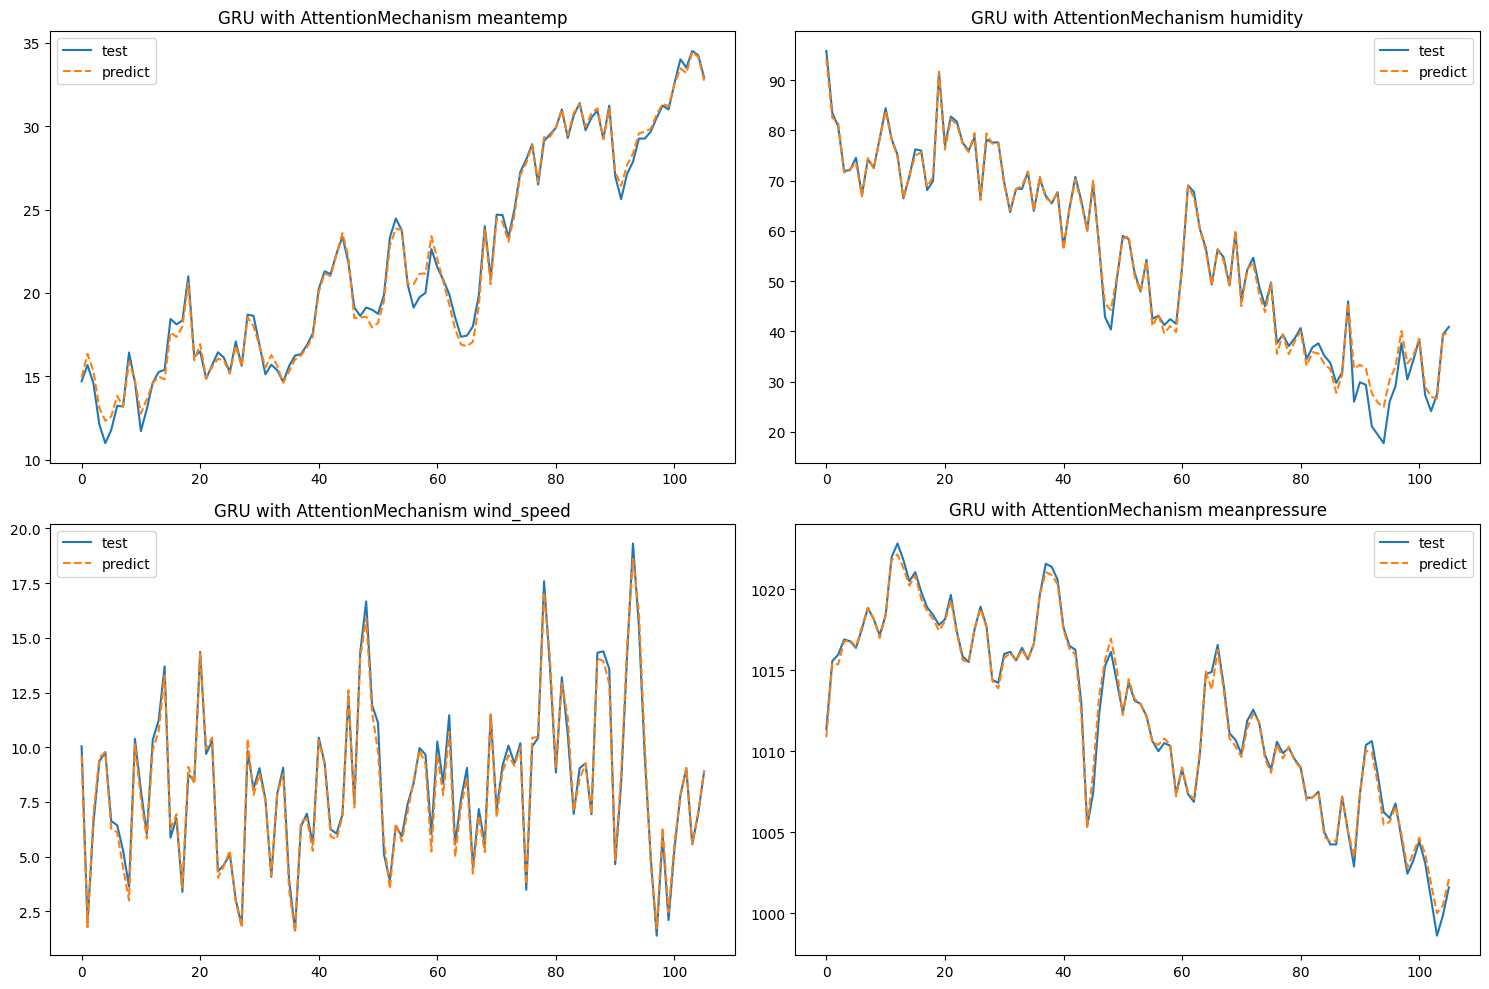

In [ ]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.plot(y_test_inv_meantemp, label='test')
plt.plot(pred_inv_meantemp, label='predict', linestyle='--')
plt.title('GRU with AttentionMechanism meantemp')
plt.legend()

plt.subplot(2,2,2)
plt.plot(y_test_inv_humidity, label='test')
plt.plot(pred_inv_humidity, label='predict', linestyle='--')
plt.title('GRU with AttentionMechanism humidity')
plt.legend()

plt.subplot(2,2,3)
plt.plot(y_test_inv_wind_speed, label='test')
plt.plot(pred_inv_wind_speed, label='predict', linestyle='--')
plt.title('GRU with AttentionMechanism wind_speed')
plt.legend()

plt.subplot(2,2,4)
plt.plot(y_test_inv_meanpressure, label='test')
plt.plot(pred_inv_meanpressure, label='predict', linestyle='--')
plt.title('GRU with AttentionMechanism meanpressure')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
mape_gru_att_meantemp = mean_absolute_percentage_error(y_test_inv_meantemp, pred_inv_meantemp)
mae_gru_att_meantemp = mean_absolute_error(y_test_inv_meantemp, pred_inv_meantemp)
print(f"MAPE meantemp: {mape_gru_att_meantemp}%")
print(f"MAE meantemp: {mae_gru_att_meantemp}\n")


mape_gru_att_humidity = mean_absolute_percentage_error(y_test_inv_humidity, pred_inv_humidity)
mae_gru_att_humidity = mean_absolute_error(y_test_inv_humidity, pred_inv_humidity)
print(f"MAPE humidity: {mape_gru_att_humidity}%")
print(f"MAE humidity: {mae_gru_att_humidity}\n")


mape_gru_att_wind_speed = mean_absolute_percentage_error(y_test_inv_wind_speed, pred_inv_wind_speed)
mae_gru_att_wind_speed = mean_absolute_error(y_test_inv_wind_speed, pred_inv_wind_speed)
print(f"MAPE wind_speed: {mape_gru_att_wind_speed}%")
print(f"MAE wind_speed: {mae_gru_att_wind_speed}\n")


mape_gru_att_meanpressure = mean_absolute_percentage_error(y_test_inv_meanpressure, pred_inv_meanpressure)
mae_gru_att_meanpressure = mean_absolute_error(y_test_inv_meanpressure, pred_inv_meanpressure)
print(f"MAPE meanpressure: {mape_gru_att_meanpressure}%")
print(f"MAE meanpressure: {mae_gru_att_meanpressure}")

MAPE meantemp: 2.0157451725340065%
MAE meantemp: 0.36953730134881535

MAPE humidity: 3.291921406980695%
MAE humidity: 1.0823625847477916

MAPE wind_speed: 4.430727497864268%
MAE wind_speed: 0.31220849770133485

MAPE meanpressure: 0.028418850174177647%
MAE meanpressure: 0.2873542626706306


# Total

In [ ]:
data = {
    'Model': ['RNN', 'RNN with AttentionMechanism',
              'LSTM', 'LSTM with AttentionMechanism',
              'GRU', 'GRU with AttentionMechanism'],
    'MAPE meantemp': [mape_rnn_meantemp, mape_rnn_att_meantemp,
                      mape_lstm_meantemp, mape_lstm_att_meantemp,
                      mape_gru_meantemp, mape_gru_att_meantemp],
    'MAPE humidity': [mape_rnn_humidity, mape_rnn_att_humidity,
                      mape_lstm_humidity, mape_lstm_att_humidity,
                      mape_gru_humidity, mape_gru_att_humidity],
    'MAPE wind_speed': [mape_rnn_wind_speed, mape_rnn_att_wind_speed,
                        mape_lstm_wind_speed, mape_lstm_att_wind_speed,
                        mape_gru_wind_speed, mape_gru_att_wind_speed],
    'MAPE meanpressure': [mape_rnn_meanpressure, mape_rnn_att_meanpressure,
                          mape_lstm_meanpressure, mape_lstm_att_meanpressure,
                          mape_gru_meanpressure, mape_gru_att_meanpressure],
    'MAE meantemp': [mae_rnn_meantemp, mae_rnn_att_meantemp,
                     mae_lstm_meantemp, mae_lstm_att_meantemp,
                     mae_gru_meantemp, mae_gru_att_meantemp],
    'MAE humidity': [mae_rnn_humidity, mae_rnn_att_humidity,
                     mae_lstm_humidity, mae_lstm_att_humidity,
                     mae_gru_humidity, mae_gru_att_humidity],
    'MAE wind_speed': [mae_rnn_wind_speed, mae_rnn_att_wind_speed,
                       mae_lstm_wind_speed, mae_lstm_att_wind_speed,
                       mae_gru_wind_speed, mae_gru_att_wind_speed],
    'MAE meanpressure': [mae_rnn_meanpressure, mae_rnn_att_meanpressure,
                         mae_lstm_meanpressure, mae_lstm_att_meanpressure,
                         mae_gru_meanpressure, mae_gru_att_meanpressure]
}

models = pd.DataFrame(data)
models

,Model,MAPE meantemp,MAPE humidity,MAPE wind_speed,MAPE meanpressure,MAE meantemp,MAE humidity,MAE wind_speed,MAE meanpressure
0,RNN,3.136686,5.144072,9.750721,0.051067,0.598541,2.055429,0.729222,0.516289
1,RNN with AttentionMechanism,2.515519,3.765003,7.628060,0.053380,0.481731,1.492737,0.459084,0.539852
2,LSTM,1.042719,1.149663,16.224748,0.020895,0.184894,0.477993,1.153892,0.211389
3,LSTM with AttentionMechanism,2.176066,3.433251,6.522925,0.072160,0.372759,1.235699,0.353718,0.729619
4,GRU,0.741289,0.825737,4.899563,0.011631,0.129204,0.307125,0.300566,0.117542
5,GRU with AttentionMechanism,2.015745,3.291921,4.430727,0.028419,0.369537,1.082363,0.312208,0.287354
